<a href="https://colab.research.google.com/github/hantq2018/CS2225.CH1801.N014/blob/NhaBT/FaceDetectionFromWebCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import cv2
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline
# filter out the warnings
import warnings
warnings.filterwarnings('ignore')

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [24]:
!pip3 install imageai --upgrade
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml -P drive/gaze

!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -P drive/gaze
cascades_path = 'drive/gaze/'
face_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_eye.xml')

Requirement already up-to-date: imageai in /usr/local/lib/python3.6/dist-packages (2.1.5)
--2020-09-21 12:53:52--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341406 (333K) [text/plain]
Saving to: ‘drive/gaze/haarcascade_eye.xml.3’

haarcascade_eye.xml 100%[===================>] 333.40K  --.-KB/s    in 0.06s   

2020-09-21 12:53:52 (5.28 MB/s) - ‘drive/gaze/haarcascade_eye.xml.3’ saved [341406/341406]

--2020-09-21 12:53:52--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw

In [25]:
import time
import os

def download_image(image_url):
    os.system('wget ' + image_url + ' -P drive/gaze')
    file_path_parts = image_url.split('/')
    return 'drive/gaze/' + file_path_parts[-1]

def current_time():
    return int(round(time.time() * 1000))

def detect_eyes(face, img, gray):
    [x,y,w,h] = face
    roi_gray = gray[y:y+h, x:x+w]

    eyes = eye_cascade.detectMultiScale(roi_gray)
    eyes_sorted_by_size = sorted(eyes, key=lambda x: -x[2])
    largest_eyes = eyes_sorted_by_size[:2]
    # sort by x position
    largest_eyes.sort(key=lambda x: x[0])
    # offset by face start
    return list(map(lambda eye: [face[0] + eye[0], face[1] + eye[1], eye[2], eye[3]], largest_eyes))

def get_face_grid(face, frameW, frameH, gridSize):
    faceX,faceY,faceW,faceH = face

    return faceGridFromFaceRect(frameW, frameH, gridSize, gridSize, faceX, faceY, faceW, faceH, False)

def extract_image_features(image_url):
    #image_path = download_image(image_url)
    img = cv2.imread(image_url)
    start_ms = current_time()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_detections = face_cascade.detectMultiScale(gray, 1.3, 5)
    #  print('face detection took ' + str((current_time() - start_ms) / 1000.))

    left_to_right_face_detections = sorted(face_detections, key=lambda detection: detection[0])

    faces = []
    face_features = []
    for [x,y,w,h] in left_to_right_face_detections:
        face = [x, y, w, h]
        #  start_eyes = current_time()
        eyes = detect_eyes(face, img, gray)
        #  print('eye extraction '  + str((current_time() - start_eyes) / 1000.))
        face_grid = get_face_grid(face, img.shape[1], img.shape[0], 25)

        faces.append(face)
        face_features.append([eyes, face_grid])

    duration_ms = current_time() - start_ms
    #  print("Face and eye extraction took: ", str(duration_ms / 1000) + "s")

    return img, faces, face_features

In [26]:
def faceGridFromFaceRect(frameW, frameH, gridW, gridH, labelFaceX, labelFaceY, labelFaceW, labelFaceH, parameterized):

    scaleX = gridW / frameW
    scaleY = gridH / frameH
    
    if parameterized:
      labelFaceGrid = np.zeros(4)
    else:
      labelFaceGrid = np.zeros(gridW * gridH)
    
    grid = np.zeros((gridH, gridW))

    # Use one-based image coordinates.
    xLo = round(labelFaceX * scaleX)
    yLo = round(labelFaceY * scaleY)
    w = round(labelFaceW * scaleX)
    h = round(labelFaceH * scaleY)

    if parameterized:
        labelFaceGrid = [xLo, yLo, w, h]
    else:
        xHi = xLo + w
        yHi = yLo + h

        # Clamp the values in the range.
        xLo = int(min(gridW, max(0, xLo)))
        xHi = int(min(gridW, max(0, xHi)))
        yLo = int(min(gridH, max(0, yLo)))
        yHi = int(min(gridH, max(0, yHi)))

        faceLocation = np.ones((yHi - yLo, xHi - xLo))
        grid[yLo:yHi, xLo:xHi] = faceLocation

        # Flatten the grid.
        grid = np.transpose(grid)
        labelFaceGrid = grid.flatten()
        
    return labelFaceGrid

In [35]:
def set_title_and_hide_axis(title):
    plt.title(title)
    plt.axes().get_xaxis().set_visible(False)
    plt.axes().get_yaxis().set_visible(False)

def render_face_grid(face_grid):
    to_print = np.copy(face_grid)
    result_image = np.copy(to_print).reshape(25, 25).transpose()
    plt.figure()
    set_title_and_hide_axis('Face grid')
    plt.imshow(result_image)

def show_extraction_results(img, faces, face_features):
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation="bicubic")

    for i, face in enumerate(faces):
        print('Face #' + str(i))
        eyes, face_grid = face_features[i]
        [x, y, w, h] = face
        set_title_and_hide_axis('Extracted face image')
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

        for [ex,ey,ew,eh] in eyes:
            cv2.rectangle(img,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        
        #plt.figure()
        #render_face_grid(face_grid)

<IPython.core.display.Javascript object>

Saved to photo.jpg


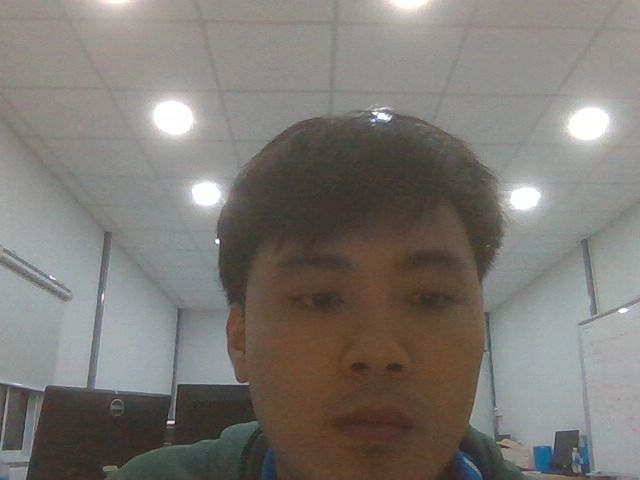

In [31]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [29]:
img, faces, face_features = extract_image_features('photo.jpg')

Face #0


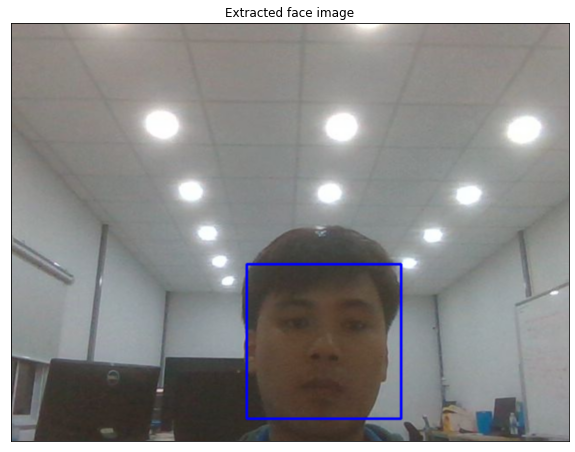

In [36]:
show_extraction_results(img, faces, face_features)